<a href="https://nbviewer.org/github/alisonmitchell/Stock-Prediction/blob/main/Sentiment_Analysis/BERT_Long_Text_Classification.ipynb"
   target="_parent">
   <img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg"
      width="109" height="20" alt="render in nbviewer">
</a>



## 1. Introduction


Here we will investigate the influence of news article sentiment on next-day AstraZeneca stock price direction by fine-tuning BERT for sentiment analysis, performing the required text preprocessing and formatting, building a Sentiment Classifier with the Hugging Face transformers library, and evaluating the model on test data.

For our supervised task of classifying sentiment as positive (1) or negative (0) we will fine-tune a pre-trained BERT model to give outputs for classification using the BertForSequenceClassification class. This adds a single untrained linear layer on top of the pooled output so that, as we add data, the pre-trained BERT model and the additional untrained classification layer is trained on our article sentiment classification task.







## 2. Install/import libraries



In [ ]:
!pip install transformers

In [ ]:
# Libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

# Tokenize to add stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Data loading utility
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

# Models
from torch import nn
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_error()

# Training
from torch import optim

# Evaluation
from sklearn.metrics import accuracy_score, matthews_corrcoef


# specify GPU device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Import data

Read article sentiment and historical stock price data into a DataFrame.

In [ ]:
article_sentiments = pd.read_pickle('azn_prices_labels_news.pkl')
article_sentiments

,Adj Close Next,Label,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,...,body_text,url,neg,neu,pos,compound,news_combined,news_cleaned,subjectivity,polarity
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-09,3107.829346,0,3822.5,3991.316895,3817.752930,3944.5,3120.884033,2974767,AZN.L,2016-05-09,...,"Published May 09, 2016 17:05\n\n© Reuters. Swe...",https://uk.investing.com//news/stock-market-ne...,0.036,0.933,0.031,-0.3818,"Published May 09, 2016 17:05\n\n© Reuters. Swe...",Published May 09 2016 1705 Reuters Sweden sh...,0.608889,0.029444
2016-05-12,3117.323242,1,3918.5,3981.150879,3874.500000,3880.0,3069.852051,2221661,AZN.L,2016-05-12,...,"Published May 12, 2016 08:02 Updated May 12, 2...",https://uk.investing.com//news/stock-market-ne...,0.168,0.694,0.138,-0.9485,"Published May 12, 2016 08:02 Updated May 12, 2...",Published May 12 2016 0802 Updated May 12 2016...,0.447153,0.074172
2016-05-17,3086.071289,0,3945.0,3962.500000,3915.639893,3930.5,3109.807617,2080482,AZN.L,2016-05-17,...,"Published May 17, 2016 20:38\n\n© Reuters. Fil...",https://uk.investing.com//news/stock-market-ne...,0.064,0.863,0.073,-0.7582,"Published May 17, 2016 20:38\n\n© Reuters. Fil...",Published May 17 2016 2038 Reuters File phot...,0.414360,0.060816
2016-05-18,3016.050537,0,3924.0,3996.110107,3883.000000,3900.5,3086.071289,2062546,AZN.L,2016-05-18,...,"Published May 18, 2016 07:55\n\n© Reuters. Chi...",https://uk.investing.com//news/stock-market-ne...,0.060,0.825,0.115,0.9962,"Published May 18, 2016 07:55\n\n© Reuters. Chi...",Published May 18 2016 0755 Reuters Chief Exe...,0.397084,0.115780
2016-05-25,3173.894531,0,3988.5,4044.899902,3974.850098,4014.5,3176.268311,2038005,AZN.L,2016-05-25,...,"Published May 25, 2016 10:10 Updated May 25, 2...",https://uk.investing.com//news/stock-market-ne...,0.051,0.878,0.071,0.8946,"Published May 25, 2016 10:10 Updated May 25, 2...",Published May 25 2016 1010 Updated May 25 2016...,0.321557,0.042688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,6724.666016,0,7307.0,7324.000000,7196.000000,7224.0,6725.597656,1588406,AZN.L,2020-12-23,...,"Published Dec 23, 2020 16:15\n\n© Reuters. U.K...",https://uk.investing.com//news/stock-market-ne...,0.036,0.933,0.031,-0.3400,"Published Dec 23, 2020 16:15\n\n© Reuters. U.K...",Published Dec 23 2020 1615 Reuters UK shares...,0.614530,0.114957
2020-12-30,6818.697266,0,7570.0,7598.000000,7400.000000,7401.0,6890.385254,2290546,AZN.L,2020-12-30,...,Street performers in Minnie Mouse costumes pas...,https://invst.ly/tar6p,0.024,0.844,0.133,0.9890,Street performers in Minnie Mouse costumes pas...,Street performers in Minnie Mouse costumes pas...,0.420452,0.110058
2020-12-31,6909.937012,1,7400.0,7409.000000,7269.000000,7324.0,6818.697266,1135354,AZN.L,2020-12-31,...,"Published Dec 31, 2020 08:42 Updated Dec 31, 2...",https://uk.investing.com//news/stock-market-ne...,0.050,0.843,0.106,0.9625,"Published Dec 31, 2020 08:42 Updated Dec 31, 2...",Published Dec 31 2020 0842 Updated Dec 31 2020...,0.363492,0.116934


## 4. Data Exploration






In [ ]:
article_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2016-05-09 to 2021-01-05
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close Next  420 non-null    float64
 1   Label           420 non-null    int64  
 2   Open            420 non-null    float64
 3   High            420 non-null    float64
 4   Low             420 non-null    float64
 5   Close           420 non-null    float64
 6   Adj Close       420 non-null    float64
 7   Volume          420 non-null    int64  
 8   ticker          420 non-null    object 
 9   publish_date    420 non-null    object 
 10  title           420 non-null    object 
 11  body_text       420 non-null    object 
 12  url             420 non-null    object 
 13  neg             420 non-null    float64
 14  neu             420 non-null    float64
 15  pos             420 non-null    float64
 16  compound        420 non-null    float64
 17  news_combined   

### 4.1 Data visualisation for price direction and sentiment label counts
The Label column was created by calculating whether the next-day Adjusted Close price increased/held or decreased.

Where prices either rose or held, the classes have been combined giving a value of '1' , and a value of '0' indicates where prices fell.

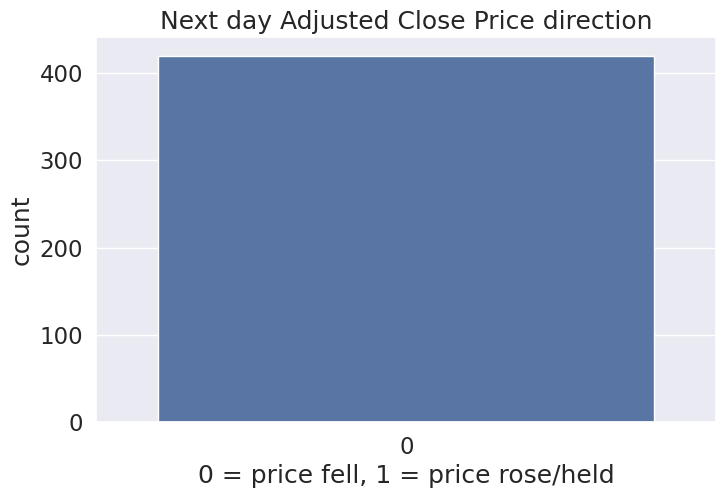

In [ ]:
# Plot showing whether Adjusted Close price increased/held or decreased

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,5)

# Plot the counts of observations in each categorical bin
sns.countplot(article_sentiments.Label)

# Label the plot
plt.title('Next day Adjusted Close Price direction')
plt.xlabel('0 = price fell, 1 = price rose/held');

Combining the increased and held classes gives a fairly even balance with the class where prices fell. We will convert the dataset into negative and neutral/positive sentiment so that a drop in price corresponds to negative sentiment and a rise or hold to positive sentiment.

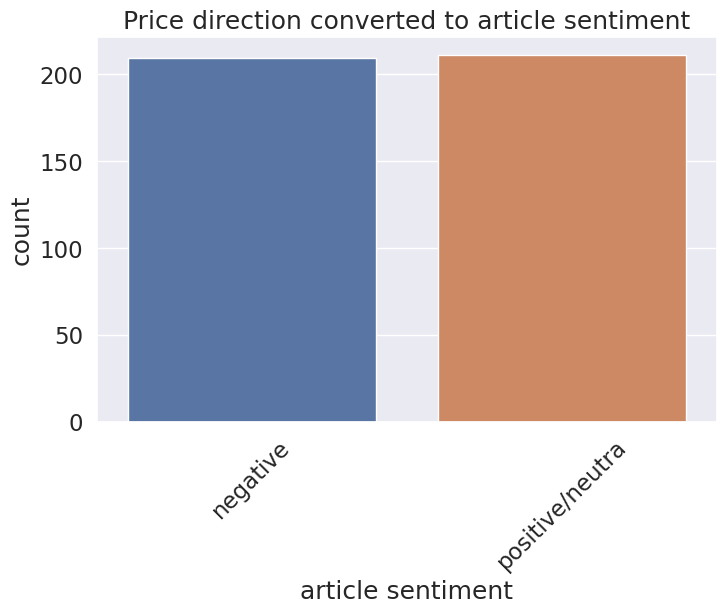

In [ ]:
# Plot showing Adjusted Close prices converted to sentiment

def to_sentiment(label):
  """
  Convert dataset into negative and neutral/positive sentiment
  """
  label = int(label)
  if label == 0:
    return 'negative'
  else:
    return 'positive/neutra'

article_sentiments['sentiment'] = article_sentiments.Label.apply(to_sentiment)

class_names = article_sentiments['sentiment'].unique()
class_names = class_names.tolist()

# Plot the counts of observations in each categorical bin
ax = sns.countplot(data=article_sentiments, x='sentiment', order=class_names)

# Label the plot
plt.title('Price direction converted to article sentiment')
plt.xlabel('article sentiment')
ax.set_xticklabels(class_names, rotation=45);

The properties we are interested in are the individual articles (news_cleaned) and their label which we will now interpret as sentiment with '1' being neutral/positive and '0' being negative.

In [ ]:
# Extract the articles and their labels as numpy ndarrays

articles = article_sentiments.news_cleaned.values
labels = article_sentiments.Label.values


## 5. Text preprocessing



### 5.1 Tokensation

Tokenisation is a way of separating text into smaller units called tokens, most commonly using space as a delimiter. Types can be broadly classified as word, character and subword (n-gram) tokenisation.

Word tokenisation is the most commonly used tokenisation algorithm and splits words into their own strings to facilitate counting, for example.

In [ ]:
tokens = [word_tokenize(article) for article in articles]
text = nltk.Text(tokens)
text

<Text: ['Published', 'May', '09', '2016', '1705', 'Reuters', 'Sweden', 'shares', 'higher', 'at', 'close', 'of', 'trade', 'OMX', 'Stockholm', '30', 'up', '145', 'BOL', '050', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'ORRON', '000', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'HMb', '058', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'SSABa', '134', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'AZN', '070', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'GETIBs', '000', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'OMXS30', '070', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'SX500', '041', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'SX20PI', '102', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'SX30PI', '091', 'Add', 'toRemove', 'from', 'a', 'Portfolio', 'Investingcom', 'Sweden', 'equities', 'were', 'higher', 'at', 'the', 'close', 'on', 'Monday', 'as', 'gains', 'in', 'the', 'and', 'sectors', 'propelled', 'shares', 'higher', 'At', 'the', 'close', 'in', 'Stockholm', 'the', 'gained', '

### 5.2 Removing Stopwords

Stopwords are some of the most common words and are necessary for sentences to be grammatically correct (e.g. a, is, an, the, and). However, they carry very little or no useful information and are filtered out as part of the text preprocessing stage to remove noise so that machine learning algorithms can better focus on the signal, or words which define the meaning of the text.

We will use the list from nltk.corpus and exclude tokens with characters that are not alphabetical using the isalpha() method which method in Python is used to check whether a given string consists of alphabetical characters

In [ ]:
stop_words = set(stopwords.words('english'))

#Iterate through all tokens for all articles
filtered_articles = [[word for word in article if not word in stop_words if word.isalpha()] for article in tokens]
print(stop_words)
print(filtered_articles)

{'all', 'm', "hadn't", 'this', 'as', 'doesn', 've', "doesn't", 'from', 'that', 'an', "aren't", "shouldn't", 'if', 'on', 'shan', 'but', 'couldn', 'then', 'hadn', "hasn't", 'herself', 'or', 'weren', 'yourselves', 'theirs', 'is', 'against', 'through', 'under', 'isn', 'and', 're', 'ours', "isn't", 'shouldn', 'while', 'me', 't', "you're", 'for', 'what', 'has', 'should', 'wasn', 'y', 'are', 'again', 'both', "won't", 'up', 'off', 'no', 'more', 'than', 's', 'we', 'itself', 'needn', 'his', 'him', 'only', 'down', 'how', 'nor', 'now', 'aren', "it's", 'himself', 'these', "she's", 'o', 'which', 'am', "wouldn't", 'until', "mightn't", 'by', 'in', "didn't", 'them', 'being', "don't", 'haven', 'any', "you've", 'will', 'did', 'myself', 'before', 'few', 'mustn', 'when', "you'll", 'some', 'yourself', 'who', 'was', 'not', 'the', 'below', 'same', 'he', 'been', 'once', 'wouldn', "mustn't", 'with', 'other', 'you', 'll', 'it', 'having', 'they', 'won', 'after', 'mightn', 'yours', 'over', "that'll", 'of', 'own', 

In [ ]:
# Join the tokens back into a list of articles

filtered_articles_joined = [','.join(article).replace(',', ' ') for article in filtered_articles]
filtered_articles_joined

['Published May Reuters Sweden shares higher close trade OMX Stockholm BOL Add toRemove Portfolio ORRON Add toRemove Portfolio HMb Add toRemove Portfolio SSABa Add toRemove Portfolio AZN Add toRemove Portfolio GETIBs Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Investingcom Sweden equities higher close Monday gains sectors propelled shares higher At close Stockholm gained The biggest gainers session Getinge AB ser B ST rose points trade close AstraZeneca PLC ST added points end Hennes Mauritz AB H M ser B ST points late trade Biggest losers included SSAB AB ser A ST lost points trade late trade Boliden AB ST declined points end Lundin Petroleum AB ST shed points Advancing stocks outnumbered falling ones ended unchanged Stockholm Stock Exchange In commodities trading Crude oil June delivery barrel Meanwhile Brent oil delivery July fell hit barrel June Gold contract fell trade troy ounce EURSEK USDSEK rose The US Dolla

In [ ]:
# Create column for filtered articles with stopwords removed

article_sentiments['filtered_articles_joined'] = filtered_articles_joined
article_sentiments.head()

,Adj Close Next,Label,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,...,neg,neu,pos,compound,news_combined,news_cleaned,subjectivity,polarity,sentiment,filtered_articles_joined
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-09,3107.829346,0,3822.5,3991.316895,3817.752930,3944.5,3120.884033,2974767,AZN.L,2016-05-09,...,0.036,0.933,0.031,-0.3818,"Published May 09, 2016 17:05\n\n© Reuters. Swe...",Published May 09 2016 1705 Reuters Sweden sh...,0.608889,0.029444,negative,Published May Reuters Sweden shares higher clo...
2016-05-12,3117.323242,1,3918.5,3981.150879,3874.500000,3880.0,3069.852051,2221661,AZN.L,2016-05-12,...,0.168,0.694,0.138,-0.9485,"Published May 12, 2016 08:02 Updated May 12, 2...",Published May 12 2016 0802 Updated May 12 2016...,0.447153,0.074172,positive/neutra,Published May Updated May Reuters A man walks ...
2016-05-17,3086.071289,0,3945.0,3962.500000,3915.639893,3930.5,3109.807617,2080482,AZN.L,2016-05-17,...,0.064,0.863,0.073,-0.7582,"Published May 17, 2016 20:38\n\n© Reuters. Fil...",Published May 17 2016 2038 Reuters File phot...,0.414360,0.060816,negative,Published May Reuters File photo Swiss drugmak...
2016-05-18,3016.050537,0,3924.0,3996.110107,3883.000000,3900.5,3086.071289,2062546,AZN.L,2016-05-18,...,0.060,0.825,0.115,0.9962,"Published May 18, 2016 07:55\n\n© Reuters. Chi...",Published May 18 2016 0755 Reuters Chief Exe...,0.397084,0.115780,negative,Published May Reuters Chief Executive AstraZen...
2016-05-25,3173.894531,0,3988.5,4044.899902,3974.850098,4014.5,3176.268311,2038005,AZN.L,2016-05-25,...,0.051,0.878,0.071,0.8946,"Published May 25, 2016 10:10 Updated May 25, 2...",Published May 25 2016 1010 Updated May 25 2016...,0.321557,0.042688,negative,Published May Updated May Reuters The Sanofi l...


In [ ]:
# Extract the filtered articles and labels as numpy ndarrays

articles = article_sentiments.filtered_articles_joined.values
labels = article_sentiments.Label.values

## 6. BertTokenizer

Machine learning models don't work with raw text so we need to transform the dataset into a format BERT can be trained on.

To feed our text into BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokeniser vocabulary.

We will load a pre-trained BertTokenizer to perform the tokenisation using the “bert-base-uncased” version of the tokeniser model which is trained on lower case English text, and tokenised using WordPiece (sub-word segmentation algorithm) and a vocabulary size of 30,000.






In [ ]:
# Initialize tokeniser
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Print the original unfiltered article still with non-alpha characters
print(' Original: ', article_sentiments.news_cleaned[0])

 Original:  Published May 09 2016 1705   Reuters Sweden shares higher at close of trade OMX Stockholm 30 up 145  BOL 050 Add toRemove from a Portfolio ORRON 000 Add toRemove from a Portfolio HMb 058 Add toRemove from a Portfolio SSABa 134 Add toRemove from a Portfolio AZN 070 Add toRemove from a Portfolio GETIBs 000 Add toRemove from a Portfolio OMXS30 070 Add toRemove from a Portfolio SX500 041 Add toRemove from a Portfolio SX20PI 102 Add toRemove from a Portfolio SX30PI 091 Add toRemove from a Portfolio  Investingcom  Sweden equities were higher at the close on Monday as gains in the  and sectors propelled shares higher  At the close in Stockholm the gained 145  The biggest gainers of the session on the were Getinge AB ser B ST  which rose 458 or 76 points to trade at 1735 at the close AstraZeneca PLC ST  added 380 or 172 points to end at 4700 and Hennes  Mauritz AB H  M ser B ST  was up 275 or 73 points to 2727 in late trade  Biggest losers included SSAB AB ser A ST  which lost 698 

Printing out the original unfiltered article shows the non-alpha characters such as dates and quantities before these were removed by filtering. We will now print out a filtered version for comparison and run the pre-trained BertTokenizer on the filtered version just to see the output which will convert the text to tokens and tokens to unique integers (ids).

In [ ]:
# Apply the tokeniser to one article just to see the output.

# Print the filtered article.
print('Filtered: ', filtered_articles_joined[0])

# Print the article split into tokens.
print('Tokenized: ', tokenizer.tokenize(filtered_articles_joined[0]))

# Print the article mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(filtered_articles_joined[0])))

Filtered:  Published May Reuters Sweden shares higher close trade OMX Stockholm BOL Add toRemove Portfolio ORRON Add toRemove Portfolio HMb Add toRemove Portfolio SSABa Add toRemove Portfolio AZN Add toRemove Portfolio GETIBs Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Investingcom Sweden equities higher close Monday gains sectors propelled shares higher At close Stockholm gained The biggest gainers session Getinge AB ser B ST rose points trade close AstraZeneca PLC ST added points end Hennes Mauritz AB H M ser B ST points late trade Biggest losers included SSAB AB ser A ST lost points trade late trade Boliden AB ST declined points end Lundin Petroleum AB ST shed points Advancing stocks outnumbered falling ones ended unchanged Stockholm Stock Exchange In commodities trading Crude oil June delivery barrel Meanwhile Brent oil delivery July fell hit barrel June Gold contract fell trade troy ounce EURSEK USDSEK rose The

We can see by printing out the filtered version above that the non-alpha characters have been removed but after applying the BertTokenizer to the article the OOV (Out-Of-Vocabulary) words, such as Astrazeneca and Pfizer, are being broken down into sub-words with ## used to represent sub-words.

We can resolve this issue by adding new tokens to the pre-trained BertTokenizer and then retraining the model.

In [ ]:
# https://stackoverflow.com/questions/62082938/how-to-stop-bert-from-breaking-apart-specific-words-into-word-piece

# Add OOV words to tokeniser
tokenizer.add_tokens(['astrazeneca', 'pfizer'])

2

In [ ]:
# Print the filtered article.
print('Filtered: ', filtered_articles_joined[0])

# Print the article split into tokens.
print('Tokenized: ', tokenizer.tokenize(filtered_articles_joined[0]))

# Print the article mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(filtered_articles_joined[0])))

Filtered:  Published May Reuters Sweden shares higher close trade OMX Stockholm BOL Add toRemove Portfolio ORRON Add toRemove Portfolio HMb Add toRemove Portfolio SSABa Add toRemove Portfolio AZN Add toRemove Portfolio GETIBs Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Investingcom Sweden equities higher close Monday gains sectors propelled shares higher At close Stockholm gained The biggest gainers session Getinge AB ser B ST rose points trade close AstraZeneca PLC ST added points end Hennes Mauritz AB H M ser B ST points late trade Biggest losers included SSAB AB ser A ST lost points trade late trade Boliden AB ST declined points end Lundin Petroleum AB ST shed points Advancing stocks outnumbered falling ones ended unchanged Stockholm Stock Exchange In commodities trading Crude oil June delivery barrel Meanwhile Brent oil delivery July fell hit barrel June Gold contract fell trade troy ounce EURSEK USDSEK rose The

We can see that the sub-words have now been replaced by 'astrazeneca' and 'pfizer' tokens which are mapped to their index in the tokeniser vocabulary.

### 6.1 Required formatting

BERT requires specifically formatted inputs. We need to:

1.   Add **special tokens** to the start and end of each each consecutive span of text by appending **`[SEP]`** at the end to separate each sentence, and prepending **`[CLS]`** to the beginning so BERT knows we’re doing classification.
2.   **Pad** and truncate all sentences to a single fixed length of maximum 512 tokens. For sentences that are shorter than this maximum length, padding is done with a special **`[PAD]`** (empty) token at index 0 in the BERT vocabulary to make up the length.
3.   Create an **attention mask**, or array of 0s (padding tokens) and 1s (real tokens) to explicitly differentiate the two and tell the “Self-Attention” mechanism in BERT not to incorporate these **`[PAD]`** tokens into its interpretation of the sentence.








In [ ]:
# Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.
# The below cell will perform one tokenisation pass of the dataset in order to measure the maximum sentence length.

max_len = 0

# For every article...
for article in article_sentiments.filtered_articles_joined:

    # Tokenise the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(article, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max article length: ', max_len)

Max article length:  3455


Here the maximum length after a tokenisation pass of the whole dataset is 3455, which is clearly too high if the maximum length the model can handle is 512 tokens.

We will store the token length of each article and plot the distribution.

In [ ]:
# Create empty list to append token length
token_lens = []

for txt in article_sentiments.filtered_articles_joined:
  tokens = tokenizer.encode(txt, max_length=7792)
  token_lens.append(len(tokens))

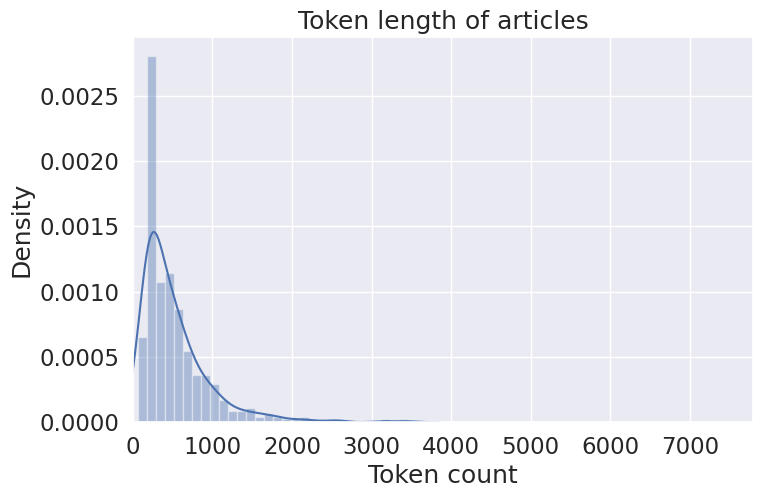

In [ ]:
# Plot the distribution of token length of dataset
sns.distplot(token_lens)

# Label the plot
plt.title('Token length of articles')
plt.xlim([0, 7792]);
plt.xlabel('Token count');

### 6.2 BERT for long text inputs

We will follow the main ideas of this [research paper](https://arxiv.org/abs/1910.10781) to overcome the fixed-length sentence limitation to be able to use BERT for encoding long sequences of text. This requires segmenting
the input into smaller chunks of 200 tokens each, with 50 tokens overlapping, and feeding each of them into the
base model.

In [ ]:
# Segment text into smaller chunks of 200 tokens each with a shift of 50 tokens

# Function to split out text

def get_split(text1):
  l_total = []
  l_partial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else:
    n = 1
  for w in range(n):
    if w == 0:
      l_partial = text1.split()[:200]
      l_total.append(" ".join(l_partial))
    else:
      l_partial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_partial))
  return l_total

Appyling the above function to the whole dataset will give us a column where every row contains a list of strings with length of around 200 words.

In [ ]:
# Apply get_split() function to every row in our dataset

article_sentiments['filtered_articles_split'] = article_sentiments['filtered_articles_joined'].apply(get_split)
article_sentiments.head()

,Adj Close Next,Label,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,...,neu,pos,compound,news_combined,news_cleaned,subjectivity,polarity,sentiment,filtered_articles_joined,filtered_articles_split
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-09,3107.829346,0,3822.5,3991.316895,3817.752930,3944.5,3120.884033,2974767,AZN.L,2016-05-09,...,0.933,0.031,-0.3818,"Published May 09, 2016 17:05\n\n© Reuters. Swe...",Published May 09 2016 1705 Reuters Sweden sh...,0.608889,0.029444,negative,Published May Reuters Sweden shares higher clo...,[Published May Reuters Sweden shares higher cl...
2016-05-12,3117.323242,1,3918.5,3981.150879,3874.500000,3880.0,3069.852051,2221661,AZN.L,2016-05-12,...,0.694,0.138,-0.9485,"Published May 12, 2016 08:02 Updated May 12, 2...",Published May 12 2016 0802 Updated May 12 2016...,0.447153,0.074172,positive/neutra,Published May Updated May Reuters A man walks ...,[Published May Updated May Reuters A man walks...
2016-05-17,3086.071289,0,3945.0,3962.500000,3915.639893,3930.5,3109.807617,2080482,AZN.L,2016-05-17,...,0.863,0.073,-0.7582,"Published May 17, 2016 20:38\n\n© Reuters. Fil...",Published May 17 2016 2038 Reuters File phot...,0.414360,0.060816,negative,Published May Reuters File photo Swiss drugmak...,[Published May Reuters File photo Swiss drugma...
2016-05-18,3016.050537,0,3924.0,3996.110107,3883.000000,3900.5,3086.071289,2062546,AZN.L,2016-05-18,...,0.825,0.115,0.9962,"Published May 18, 2016 07:55\n\n© Reuters. Chi...",Published May 18 2016 0755 Reuters Chief Exe...,0.397084,0.115780,negative,Published May Reuters Chief Executive AstraZen...,[Published May Reuters Chief Executive AstraZe...
2016-05-25,3173.894531,0,3988.5,4044.899902,3974.850098,4014.5,3176.268311,2038005,AZN.L,2016-05-25,...,0.878,0.071,0.8946,"Published May 25, 2016 10:10 Updated May 25, 2...",Published May 25 2016 1010 Updated May 25 2016...,0.321557,0.042688,negative,Published May Updated May Reuters The Sanofi l...,[Published May Updated May Reuters The Sanofi ...


In [ ]:
# Keep the two columns we are interested in for classification purposes

keep_columns = ['filtered_articles_split', 'Label']
df =  article_sentiments[keep_columns]
df

,filtered_articles_split,Label
Date,,
2016-05-09,[Published May Reuters Sweden shares higher cl...,0
2016-05-12,[Published May Updated May Reuters A man walks...,1
2016-05-17,[Published May Reuters File photo Swiss drugma...,0
2016-05-18,[Published May Reuters Chief Executive AstraZe...,0
2016-05-25,[Published May Updated May Reuters The Sanofi ...,0
...,...,...
2020-12-23,[Published Dec Reuters UK shares higher close ...,0
2020-12-30,[Street performers Minnie Mouse costumes pass ...,0
2020-12-31,[Published Dec Updated Dec Reuters Add toRemov...,1


### 6.3 Split into training and test data

We will split the data into training (90%) and test (10%).

In [ ]:
split = int(0.9*len(df))

In [ ]:
training_data = df[0:split]
test_data = df[split:]

In [ ]:
print(training_data.shape)
print(test_data.shape)

(378, 2)
(42, 2)


In [ ]:
print(len(training_data))
print(len(test_data))

378
42


### 6.4 Tokenise training dataset

Now that we have decided on a maximum sentence length of 200 for padding/truncating to, we can perform the real tokenisation. The transformers library provides a **`tokenizer.encode_plus`** function which simplifies the tokenisation and input formatting by the combining multiple steps of:
1.   Splitting the sentence into tokens.
2.   Adding the special **`[CLS]`** and **`[SEP]`** tokens.
2.   Mapping the tokens to their IDs.
2.   Padding or truncating all sentences to the same length.
2.   Creating the attention masks which explicitly differentiate real tokens from **`[PAD]`** tokens.









In [ ]:
# Create article and label lists
articles = training_data.filtered_articles_split.values
labels = training_data.Label.values

# Tokenise all of the articles and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence..
for article in articles:
    # `encode_plus` will:
    #   (1) Tokenise the sequence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        article,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 200,           # Pad and truncate all sentence.
                        return_token_type_ids=False,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention. masks.
                        return_tensors = 'pt',     # Return PyTorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', articles[0])
print('Token IDs:', input_ids[0])

Original:  ['Published May Reuters Sweden shares higher close trade OMX Stockholm BOL Add toRemove Portfolio ORRON Add toRemove Portfolio HMb Add toRemove Portfolio SSABa Add toRemove Portfolio AZN Add toRemove Portfolio GETIBs Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Add toRemove Portfolio Investingcom Sweden equities higher close Monday gains sectors propelled shares higher At close Stockholm gained The biggest gainers session Getinge AB ser B ST rose points trade close AstraZeneca PLC ST added points end Hennes Mauritz AB H M ser B ST points late trade Biggest losers included SSAB AB ser A ST lost points trade late trade Boliden AB ST declined points end Lundin Petroleum AB ST shed points Advancing stocks outnumbered falling ones ended unchanged Stockholm Stock Exchange In commodities trading Crude oil June delivery barrel Meanwhile Brent oil delivery July fell hit barrel June Gold contract fell trade troy ounce EURSEK USDSEK rose T

### 6.5 Training and Validation Split

We will divide up our training set to use 90% for training the model and 10% for validation of the model performance during training. This should help prevent our model from overfitting.




In [ ]:
# Combine the training inputs into a TensorDataset.
training_data = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(training_data))
valid_size = len(training_data) - train_size

# Divide the dataset by randomly selecting samples.
train_data, valid_data = random_split(training_data, [train_size, valid_size])

print(f'{train_size} training samples')
print(f'{valid_size} validation samples')

340 training samples
38 validation samples


### 6.6 DataLoader class

We will create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

The DataLoader needs to know our batch size for training. For fine-tuning BERT on a specific task, the authors of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf) recommend a batch size of 16 or 32. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

In [ ]:
# We have selected a batch size of 16 here

batch_size = 10

In [ ]:
# Create the DataLoaders for our training and validation sets.

train_data_loader = DataLoader(train_data, batch_size, sampler=RandomSampler(train_data), num_workers=4)
valid_data_loader = DataLoader(valid_data, batch_size, sampler=SequentialSampler(valid_data), num_workers=4)

## 7. Train Our Classification Model

We are now ready to fine-tune our BERT model having ensured that our input data is properly formatted.




### 7.1 BertForSequenceClassification

We will now load and modify the pre-trained BERT model to give outputs for classification using the BertForSequenceClassification class for fine-tuning. This adds an additional untrained classification layer on top of the model which is then trained on our specific task as we feed input data.

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    return_dict=False, # https://github.com/wandb/client/issues/1627 and 4. https://huggingface.co/transformers/migration.html
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

### Use GPU for training

In order for torch to use the GPU, we identifed and specified the GPU as the device in the imports at the start of the notebook.

Here we tell PyTorch to run the model on the GPU to reduce training time.

In [ ]:
# move model to GPU
#model = model.to(device)


### Model parameters

BERT base model contains an encoder with 12 Transformer layers, 12 self-attention heads, and a hidden size of 768.

We can browse all of the model’s parameters by name here and see the names and dimensions of the weights for:
1.   The embedding layer.
2.   The first of the twelve transformers.
2.   The output layer.



In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print(f'The BERT model has {len(params):} different named parameters.\n')

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print(f"{p[0]:<55} {str(tuple(p[1].size())):>12}")

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print(f"{p[0]:<55} {str(tuple(p[1].size())):>12}")

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print(f"{p[0]:<55} {str(tuple(p[1].size())):>12}")

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### 7.2 Optimiser and Learning Rate Scheduler

Now that we have loaded our “bert-base-uncased” model with BertForSequenceClassification we need to fine-tune the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

*   **Batch size:** 16, 32
*   **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
*   **Number of epochs:** 2, 3, 4

We will choose:

*   **Batch size:** 16 (set when creating our DataLoaders)
*   **Learning rate (Adam):** 2e-5
*   **Number of epochs:** 3


To reproduce the training procedure from the BERT paper, we’ll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimiser provided by the Hugging Face library (as opposed to PyTorch). It corrects weight decay (the 'W' stands for 'Weight Decay fix'), so it’s similar to the original paper. We’ll also use a linear scheduler with no warmup steps.



In [ ]:
# Parameters:
lr =  2e-5
adam_epsilon = 1e-8

# Number of training epochs (The BERT authors recommend between 2 and 4)
epochs = 3

num_warmup_steps = 0 # Default value in run_glue.py (a utility which allows you to pick which GLUE benchmark task you want to run on)
num_training_steps = len(train_data_loader) * epochs # Total number of training steps is [number of batches] x [number of epochs].

#In Transformers, optimiser and schedules are split and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behaviour set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

### 7.3 Training the model

For each pass in our training loop we have a training phase and a validation phase.

**Training phase:**

*   Set the BERT model to train mode as the default mode is evaluation.
*   Iterate over the batch and unpack our data into inputs and labels.
*   Load data onto the GPU for acceleration.
*   PyTorch by default accumulates the gradients calculated in the previous pass. Clear those previously accumulated gradients.
*   Forward pass: feeding input data through all the neurons in the network from first to last layer.
*   Backward pass (back-propagation): counting changes in weights (de facto *learning*), using gradient descent algorithm (or similar). Computation is made from last layer, backward to the first layer.
*   Post backward pass, network will perform a parameter update **`optimizer.step()`** function, based on the current gradient (stored in **`.grad`** attribute of a parameter) and the update rule.
*   Call **`scheduler.step()`** function, to update the learning rate.
*   Track variables for monitoring progress.


**Validation phase:**

*   Unpack validation data inputs and labels.
*   Load data onto the GPU for acceleration.
*   Forward pass (feed input data through the network) to predict the outputs.
*   Compute loss on our validation data and track variables for monitoring progress.








### Define helper functions

Before writing our training loop we will define helper functions for calculating accuracy of our predictions vs labels, and formatting elapsed times as **`hh:mm:ss`**

In [ ]:
# Helper function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    '''
    Calculate the accuracy of predictions vs labels

    :param preds: logits, or values which are the output of a dense (fully-connected) layer of a neural network model prior to applying an activation function like softmax
    :param labels: pytorch tensor for labels after conversion from list

    :returns: computed probability
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Helper function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Take a time in seconds and return a string hh:mm:ss

    :param elapsed: time in seconds

    :returns: time as hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Start the training

The [BERT Fine-Tuning Tutorial with Python](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) was particularly useful here.

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode as the default is evaluation mode.
    # The call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test
    # (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_data_loader):

        # Progress update every 7 batches.
        if step % 7 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print(f'  Batch {step}  of  {len(train_data_loader)}.    Elapsed: {elapsed}.')

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]

        model.zero_grad()

        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # Gradient clipping is not in AdamW anymore.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_data_loader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_data_loader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_data_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_data_loader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


======== Epoch 1 / 3 ========
Training...
  Batch 7  of  34.    Elapsed: 0:03:00.
  Batch 14  of  34.    Elapsed: 0:05:35.
  Batch 21  of  34.    Elapsed: 0:08:24.
  Batch 28  of  34.    Elapsed: 0:10:54.

  Average training loss: 0.71
  Training epoch took: 0:13:06

Running Validation...
  Accuracy: 0.41
  Validation Loss: 0.73
  Validation took: 0:00:27

======== Epoch 2 / 3 ========
Training...
  Batch 7  of  34.    Elapsed: 0:02:43.
  Batch 14  of  34.    Elapsed: 0:05:14.
  Batch 21  of  34.    Elapsed: 0:07:49.
  Batch 28  of  34.    Elapsed: 0:10:27.

  Average training loss: 0.71
  Training epoch took: 0:12:39

Running Validation...
  Accuracy: 0.41
  Validation Loss: 0.72
  Validation took: 0:00:28

======== Epoch 3 / 3 ========
Training...
  Batch 7  of  34.    Elapsed: 0:02:34.
  Batch 14  of  34.    Elapsed: 0:05:02.
  Batch 21  of  34.    Elapsed: 0:07:32.
  Batch 28  of  34.    Elapsed: 0:10:00.

  Average training loss: 0.69
  Training epoch took: 0:12:10

Running Valid

### View the summary of the training process

In [ ]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.71,0.73,0.41,0:13:06,0:00:27
2,0.71,0.72,0.41,0:12:39,0:00:28
3,0.69,0.70,0.41,0:12:10,0:00:28


We can see that both the training and validation loss are going down with each epoch and although the validation accuracy increased between the first and second epochs it did not continue to increase between the second and third.

The [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) argues that validation loss is a more precise measure than accuracy, because with accuracy we are not interested in the exact output value, only which side of a threshold it falls on. If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

In [ ]:
# Save stats

df_stats.to_pickle("bert_train_val_stats_v1.pkl")

### Plot training and validation loss





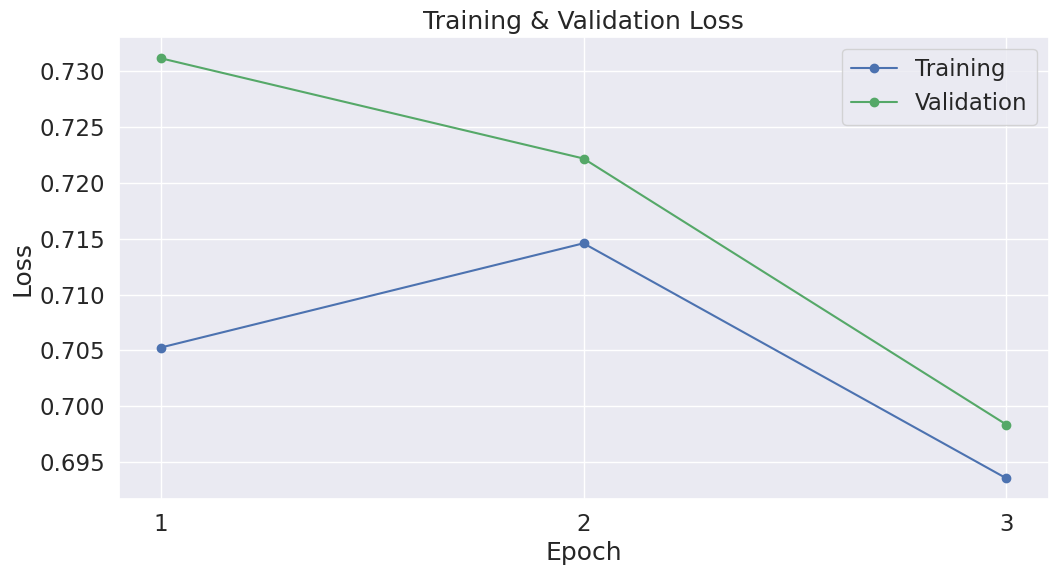

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

We will run the training loop again after changing the progress update to be every 8 instead of every 7 batches.

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode as the default is evaluation mode.
    # The call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test
    # (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_data_loader):

        # Progress update every 8 batches.
        if step % 8 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print(f'  Batch {step}  of  {len(train_data_loader)}.    Elapsed: {elapsed}.')

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]

        # Gradients get accumulated by default.
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments are given and what flags are set.
        # For our usage here, it returns the loss (because we provided labels) and the "logits" - the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # Gradient clipping is not in AdamW anymore.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_data_loader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_data_loader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_data_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_data_loader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


======== Epoch 1 / 3 ========
Training...
  Batch 8  of  34.    Elapsed: 0:02:56.
  Batch 16  of  34.    Elapsed: 0:05:50.
  Batch 24  of  34.    Elapsed: 0:08:40.
  Batch 32  of  34.    Elapsed: 0:11:30.

  Average training loss: 0.69
  Training epoch took: 0:12:12

Running Validation...
  Accuracy: 0.41
  Validation Loss: 0.70
  Validation took: 0:00:29

======== Epoch 2 / 3 ========
Training...
  Batch 8  of  34.    Elapsed: 0:02:55.
  Batch 16  of  34.    Elapsed: 0:05:47.
  Batch 24  of  34.    Elapsed: 0:08:37.
  Batch 32  of  34.    Elapsed: 0:11:30.

  Average training loss: 0.68
  Training epoch took: 0:12:14

Running Validation...
  Accuracy: 0.41
  Validation Loss: 0.70
  Validation took: 0:00:28

======== Epoch 3 / 3 ========
Training...
  Batch 8  of  34.    Elapsed: 0:02:58.
  Batch 16  of  34.    Elapsed: 0:05:48.
  Batch 24  of  34.    Elapsed: 0:08:38.
  Batch 32  of  34.    Elapsed: 0:11:31.

  Average training loss: 0.68
  Training epoch took: 0:12:14

Running Valid

In [ ]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.69,0.7,0.41,0:12:12,0:00:29
2,0.68,0.7,0.41,0:12:14,0:00:28
3,0.68,0.7,0.41,0:12:14,0:00:28


We can see that while training and validation loss do go down albeit not with every epoch, the validation accuracy score markedly decreases then increases again and so is perhaps not such a reliable metric as suggested in the tutorial.

In [ ]:
# Save stats

df_stats.to_pickle("bert_train_val_stats_v2.pkl")

### View the summary of the training process

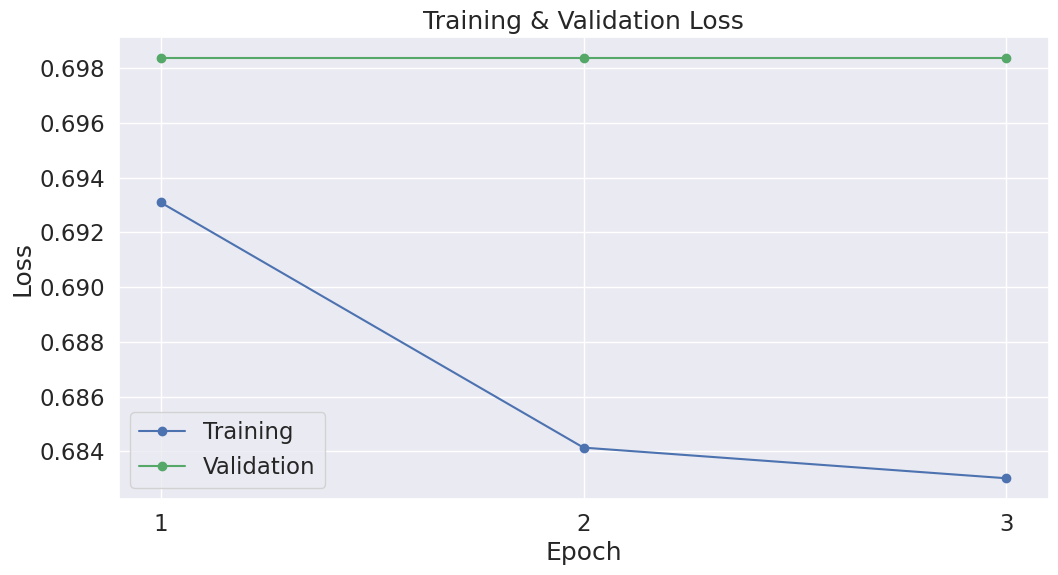

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

## 8. Performance on Test Set

We will load the test dataset and prepare inputs as we did for the training set, then evaluate predictions using [Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html).


### 8.1 Data Preparation

We will apply all of the same steps that we did for the training data to prepare our test dataset.

In [ ]:
# Print out test dataset
test_data

,filtered_articles_split,Label
Date,,
2020-10-07,[Published Oct Updated Oct Reuters FILE PHOTO ...,1
2020-10-08,[Published Oct Updated Oct Reuters Add toRemov...,1
2020-10-09,[Published Oct Updated Oct Reuters FILE PHOTO ...,1
2020-10-12,[Published Oct Reuters FILE PHOTO A syringe va...,0
2020-10-14,[Published Oct Updated Oct Interested Novacyt ...,0
2020-10-16,[Published Oct Updated Oct Reuters FILE PHOTO ...,0
2020-10-19,[Published Oct Updated Oct Reuters FILE PHOTO ...,0
2020-10-21,[Published Oct Updated Oct Reuters FILE PHOTO ...,1
2020-10-22,[Published Oct Updated Oct Reuters FILE PHOTO ...,0


In [ ]:
# Report the number of sentences.
print(f'Number of test articles: {test_data.shape[0]}\n')

# Create sentence and label lists
articles = test_data.filtered_articles_split.values
labels = test_data.Label.values

# Tokenise all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for article in articles:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        article,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 200,           # Pad and truncate all sentences.
                        return_token_type_ids=False,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_data_loader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test articles: 42



In [ ]:
for data in prediction_data_loader:
  print(data[0])
  print(data[1])

tensor([[101, 100, 102,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 102,  ...,   0,   0,   0],
        ...,
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 102,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0],
        ...,
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  

In [ ]:
input_ids

tensor([[101, 100, 102,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 102,  ...,   0,   0,   0],
        ...,
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0],
        [101, 100, 100,  ...,   0,   0,   0]])

In [ ]:
attention_masks

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
prediction_sampler

In [ ]:
torch.save(model, 'bert_long_text.pt')

### 8.2 Evaluate on Test Set

We can now apply our fine-tuned model to generate predictions on the test set.



In [ ]:
# Prediction on test set

print(f'Predicting labels for {len(input_ids)} test articles...')

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in prediction_data_loader:
  # Add batch to GPU
  batch = tuple(t.to("cpu") for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 42 test articles...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (test_data.Label.sum(), len(test_data.Label), (test_data.Label.sum() / len(test_data.Label) * 100.0)))

Positive samples: 21 of 42 (50.00%)


### 8.3 Accuracy measured using the Matthews correlation coefficient (MCC)

With this metric, +1 is the best score representing a perfect prediction, 0 an average random prediction, and -1 is the worst score representing an inverse prediction.

In [ ]:
# Print length of list of true labels, or number of input batches

len(true_labels)

3

In [ ]:
# Print arrays of true labels (label IDs) stored for each input batch

true_labels

[array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]),
 array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]),
 array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1])]

In [ ]:
# Print predictions (logits) stored for each batch as a 2-column ndarray (one column for "0" and one column for "1").
# Logits are the raw unscaled output values associated with a class prior to applying an activation function like the softmax
# to get the predicted probabilities from our trained model.

predictions

[array([[0.52997696, 0.47779775],
        [0.5301832 , 0.47976297],
        [0.52997696, 0.47779775],
        [0.53061354, 0.48233476],
        [0.53090435, 0.48321256],
        [0.52997696, 0.47779775],
        [0.52997696, 0.47779775],
        [0.53061354, 0.48233476],
        [0.5304593 , 0.4816577 ],
        [0.53094536, 0.4834438 ],
        [0.53061354, 0.48233476],
        [0.52997696, 0.47779775],
        [0.5301832 , 0.47976297],
        [0.53022933, 0.48072064],
        [0.5301832 , 0.47976297],
        [0.53061354, 0.48233476]], dtype=float32),
 array([[0.5304593 , 0.4816577 ],
        [0.52997696, 0.47779775],
        [0.53090435, 0.48321256],
        [0.5301832 , 0.47976297],
        [0.53061354, 0.48233476],
        [0.53061354, 0.48233476],
        [0.5301832 , 0.47976297],
        [0.53022933, 0.48072064],
        [0.53094536, 0.4834438 ],
        [0.52997696, 0.47779775],
        [0.52997696, 0.47779775],
        [0.53022933, 0.48072064],
        [0.53094536, 0.4834438 

In [ ]:
# Calculate the MCC score for each batch

matthews_set = []

# Evaluate each test batch using Matthews correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
# Print MCC score for each batch

matthews_set

[0.0, 0.0, 0.0]

### Barplot of MCC score for each batch

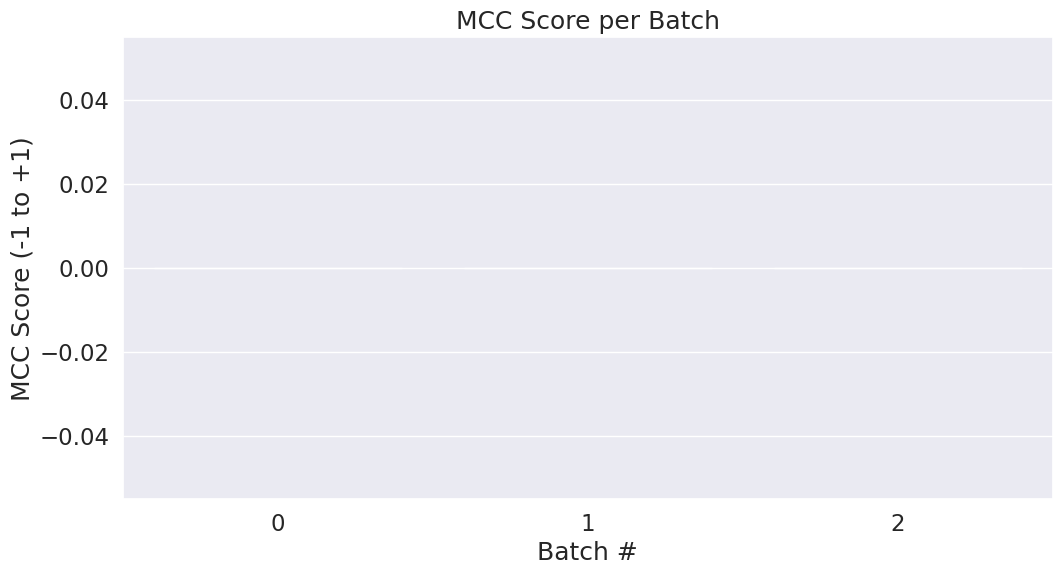

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

# Label the plot
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #');

### Calculate final MCC score

In [ ]:
# Combine the results across all batches and calculate our final MCC score
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.000


## 9. Conclusion

This notebook demonstrates the power of transfer learning by using a pre-trained BERT model which has been trained on a huge dataset and then fine-tuning it for a specific task.

The dataset used here was relatively small meaning that the accuracy can vary significantly between runs. Further work could include using the MCC score for validation accuracy or even removing the validation set altogether and training on the entire training set instead.


## 10. References

*   [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)
*   [Hierarchical Transformers for Long Document Classification](https://arxiv.org/abs/1910.10781.pdf)
*   [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
*   [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
*   [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/#choosing-sequence-length)
*   [Text Classification with BERT using Transformers for long text inputs](https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd)
*   [Using BERT For Classifying Documents with Long Texts](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d)
*   [Fine-Tuning BERT model using PyTorch](https://medium.com/@prakashakshay/fine-tuning-bert-model-using-pytorch-f34148d58a37)

